In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor

from helper_funcs import *

In [24]:
zipdata = get_zipdata()
zipdata.shape

----pulling ZipCode data from Azure storage----
----Done----


(6987, 24)

In [25]:
zipdata.isna().sum()

Population              0
HouseholdsPerZipCode    0
AverageHouseValue       0
IncomePerHousehold      0
MedianAge               0
NumberOfBusinesses      0
over_65_ratio           0
school_rating           0
Hosp_count              0
HPI                     0
Demand_score            0
Supply_score            0
listviews_vs_US         0
med_days_on_mkt         0
nielson_rank            0
UE_rate                 0
Zillow_HVF              0
BEA_percap_income       0
Blacks_ratio            0
Hispanics_ratio         0
Asians_ratio            0
Indians_ratio           0
Others_ratio            0
Male_ratio              0
dtype: int64

### Create PCAs for each type of data:
* Population (Population, Blacks_ratio, Hispanics_ratio, Asians_ratio, Indians_ratio, Others_ratio, Male_ratio, HouseholdsPerZipCode)
* Age (MedianAge, over_65_ratio)
* Economics (IncomePerHousehold, NumberOfBusinesses, UE_rate)
* FRED (HPI, Demand_score, Supply_score, listviews_vs_US, med_days_on_mkt, nielson_rank)

Not Included: Zillow, School_rating, Hosp, AverageHouseValue

In [26]:
pop_feats = ['Population', 'Blacks_ratio', 'Hispanics_ratio', 'Asians_ratio', 
             'Indians_ratio', 'Others_ratio', 'Male_ratio', 'HouseholdsPerZipCode']
age_feats = ['MedianAge', 'over_65_ratio']
econ_feats = ['IncomePerHousehold', 'NumberOfBusinesses', 'UE_rate']
fred_feats = ['HPI', 'Demand_score', 'Supply_score', 'listviews_vs_US', 'med_days_on_mkt', 'nielson_rank']

### 🎚️ Scale data before clustering

In [27]:
mms = MinMaxScaler()
# REMOVE AverageHouseValue
data_scaled = pd.DataFrame(mms.fit_transform(zipdata.drop(columns='AverageHouseValue').values), 
                           columns=zipdata.drop(columns='AverageHouseValue').columns, 
                           index=zipdata.drop(columns='AverageHouseValue').index)

In [45]:
pca = PCA(n_components=0.74)

pca.fit(data_scaled[pop_feats])
print(f'population PCA explained: {np.round(pca.explained_variance_ratio_,3)}')
print(f'number of PCA columns: {len(pca.explained_variance_ratio_)}')
pop_PCAs = pd.DataFrame(pca.fit_transform(data_scaled[pop_feats]), 
                        columns=['popPCA_'+str(n) for n in range(len(pca.explained_variance_ratio_))], 
                        index=zipdata.index)

print('---------------------------------')
pca.fit(data_scaled[age_feats])
print(f'Age PCA explained: {np.round(pca.explained_variance_ratio_,3)}')
print(f'number of PCA columns: {len(pca.explained_variance_ratio_)}')
age_PCAs = pd.DataFrame(pca.fit_transform(data_scaled[age_feats]), 
                        columns=['agePCA_'+str(n) for n in range(len(pca.explained_variance_ratio_))], 
                        index=zipdata.index)

print('---------------------------------')
pca.fit(data_scaled[econ_feats])
print(f'Econ PCA explained: {np.round(pca.explained_variance_ratio_,3)}')
print(f'number of PCA columns: {len(pca.explained_variance_ratio_)}')
econ_PCAs = pd.DataFrame(pca.fit_transform(data_scaled[econ_feats]), 
                        columns=['econPCA_'+str(n) for n in range(len(pca.explained_variance_ratio_))], 
                        index=zipdata.index)

print('---------------------------------')
pca.fit(data_scaled[fred_feats])
print(f'FRED PCA explained: {np.round(pca.explained_variance_ratio_,3)}')
print(f'number of PCA columns: {len(pca.explained_variance_ratio_)}')
fred_PCAs = pd.DataFrame(pca.fit_transform(data_scaled[fred_feats]), 
                        columns=['fredPCA_'+str(n) for n in range(len(pca.explained_variance_ratio_))], 
                        index=zipdata.index)

population PCA explained: [0.531 0.211]
number of PCA columns: 2
---------------------------------
Age PCA explained: [0.924]
number of PCA columns: 1
---------------------------------
Econ PCA explained: [0.496 0.346]
number of PCA columns: 2
---------------------------------
FRED PCA explained: [0.718 0.154]
number of PCA columns: 2


## 🎰 Model with PCAs

In [46]:
RF = get_redfin_csv()
print(RF.shape)

----pulling Redfin data from Azure storage----
----Done----
(74717, 21)


#### Merge PCA data into House data

In [47]:
print(f'shape before merge: {RF.shape}')

for each in [pop_PCAs, age_PCAs, econ_PCAs, fred_PCAs]:
    RF = RF.merge(each, how = 'left', left_on = 'zip', right_index=True)

print(f'shape after merge: {RF.shape}')

shape before merge: (74717, 21)
shape after merge: (74717, 28)


In [48]:
RF.columns

Index(['Sale_Type', 'Sold_Date', 'Prop_Type', 'ADDRESS', 'CITY', 'State',
       'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SF', 'Lot_Size', 'YearBuilt',
       'Days_on_Mkt', 'px_perSF', 'HOA_perMonth', 'STATUS', 'LATITUDE',
       'LONGITUDE', 'zip', 'Detached', 'popPCA_0', 'popPCA_1', 'agePCA_0',
       'econPCA_0', 'econPCA_1', 'fredPCA_0', 'fredPCA_1'],
      dtype='object')

In [11]:
target_feats = ['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip','popPCA_0', 'popPCA_1', 
              'popPCA_2', 'agePCA_0', 'econPCA_0', 'econPCA_1', 'fredPCA_0', 'fredPCA_1']

lm = LinearRegression()
cat = CatBoostRegressor(verbose=False)

LM_train_R2 = []
LM_test_R2 = []

CAT_train_R2 = []
CAT_test_R2 = []

for i in range(5):
    X_train_dum, X_test_dum, X_train_le, X_test_le, y_train, y_test = get_train_test(RF,target_feats)
    lm.fit(X_train_dum, y_train)
    LM_train_R2.append(lm.score(X_train_dum, y_train))
    LM_test_R2.append(lm.score(X_test_dum, y_test))
   
    cat.fit(X_train_le, y_train)
    CAT_train_R2.append(cat.score(X_train_le, y_train))
    CAT_test_R2.append(cat.score(X_test_le, y_test))
    print(i+1)

print(f'Linear Model train R2: {np.average(LM_train_R2)}')
print(f'Linear Model test R2: {np.average(LM_test_R2)}')
print(f'CatBoost train R2: {np.average(CAT_train_R2)}')
print(f'CatBoost Model test R2: {np.average(CAT_test_R2)}')

1
2
3
4
5
Linear Model train R2: 0.7550522647947447
Linear Model test R2: 0.7085374300462541
CatBoost train R2: 0.8778824262782624
CatBoost Model test R2: 0.8496457175181489


### Try again with school_rating, Zillow, Hosp

In [49]:
RF = RF.merge(zipdata[['school_rating','Zillow_HVF','Hosp_count']], how = 'left', left_on = 'zip', right_index=True)

In [50]:
target_feats = ['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip','popPCA_0', 'popPCA_1', 
                'agePCA_0', 'econPCA_0', 'econPCA_1', 'fredPCA_0', 'fredPCA_1',
                'school_rating','Zillow_HVF']

lm = LinearRegression()
cat = CatBoostRegressor(verbose=False)

LM_train_R2 = []
LM_test_R2 = []

CAT_train_R2 = []
CAT_test_R2 = []

for i in range(5):
    X_train_dum, X_test_dum, X_train_le, X_test_le, y_train, y_test = get_train_test(RF,target_feats)
    lm.fit(X_train_dum, y_train)
    LM_train_R2.append(lm.score(X_train_dum, y_train))
    LM_test_R2.append(lm.score(X_test_dum, y_test))
   
    cat.fit(X_train_le, y_train)
    CAT_train_R2.append(cat.score(X_train_le, y_train))
    CAT_test_R2.append(cat.score(X_test_le, y_test))
    print(i+1)

print(f'Linear Model train R2: {np.average(LM_train_R2)}')
print(f'Linear Model test R2: {np.average(LM_test_R2)}')
print(f'CatBoost train R2: {np.average(CAT_train_R2)}')
print(f'CatBoost Model test R2: {np.average(CAT_test_R2)}')

1
2
3
4
5
Linear Model train R2: 0.7548838514088196
Linear Model test R2: 0.7351504773922054
CatBoost train R2: 0.8794524033242945
CatBoost Model test R2: 0.8490919372897409


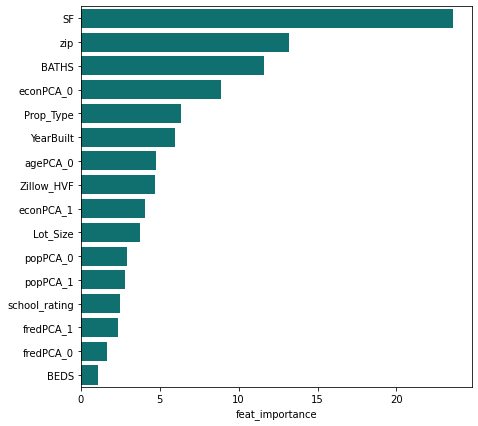

In [52]:
feat_importances = pd.DataFrame(cat.get_feature_importance(), index=X_train_le.columns, columns=['feat_importance'])
feat_importances = feat_importances.sort_values(by='feat_importance', ascending=False)

f, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x='feat_importance', y=feat_importances.index, data=feat_importances, color="teal");

# Simplify to single PCA model

In [53]:
all_feats = ['Population', 'Blacks_ratio', 'Hispanics_ratio', 'Asians_ratio', 
             'Indians_ratio', 'Others_ratio', 'Male_ratio', 'HouseholdsPerZipCode', 
             'MedianAge', 'over_65_ratio', 'IncomePerHousehold', 'NumberOfBusinesses', 
             'UE_rate', 'HPI', 'Demand_score', 'Supply_score', 'listviews_vs_US', 
             'med_days_on_mkt', 'nielson_rank']

In [62]:
pca = PCA(n_components=0.8)
pca.fit(data_scaled[all_feats])
print(f'population PCA explained: {np.round(pca.explained_variance_ratio_,3)}')
print(f'number of PCA columns: {len(pca.explained_variance_ratio_)}')
all_PCAs = pd.DataFrame(pca.fit_transform(data_scaled[all_feats]), 
                        columns=['PCA_'+str(n) for n in range(len(pca.explained_variance_ratio_))], 
                        index=zipdata.index)

population PCA explained: [0.473 0.177 0.106 0.058]
number of PCA columns: 4


In [63]:
RF = get_redfin_csv()
print(RF.shape)

----pulling Redfin data from Azure storage----
----Done----
(74717, 21)


In [64]:
RF = RF.merge(all_PCAs, how = 'left', left_on = 'zip', right_index=True)

In [65]:
RF.columns

Index(['Sale_Type', 'Sold_Date', 'Prop_Type', 'ADDRESS', 'CITY', 'State',
       'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SF', 'Lot_Size', 'YearBuilt',
       'Days_on_Mkt', 'px_perSF', 'HOA_perMonth', 'STATUS', 'LATITUDE',
       'LONGITUDE', 'zip', 'Detached', 'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3'],
      dtype='object')

In [20]:
target_feats = ['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip',
              'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3','PCA_4']

lm = LinearRegression()
cat = CatBoostRegressor(verbose=False)

LM_train_R2 = []
LM_test_R2 = []

CAT_train_R2 = []
CAT_test_R2 = []

for i in range(5):
    X_train_dum, X_test_dum, X_train_le, X_test_le, y_train, y_test = get_train_test(RF,target_feats)
    lm.fit(X_train_dum, y_train)
    LM_train_R2.append(lm.score(X_train_dum, y_train))
    LM_test_R2.append(lm.score(X_test_dum, y_test))
   
    cat.fit(X_train_le, y_train)
    CAT_train_R2.append(cat.score(X_train_le, y_train))
    CAT_test_R2.append(cat.score(X_test_le, y_test))
    print(i+1)

print(f'Linear Model train R2: {np.average(LM_train_R2)}')
print(f'Linear Model test R2: {np.average(LM_test_R2)}')
print(f'CatBoost train R2: {np.average(CAT_train_R2)}')
print(f'CatBoost Model test R2: {np.average(CAT_test_R2)}')

1
2
3
4
5
Linear Model train R2: 0.7555887712904362
Linear Model test R2: 0.7327801083383687
CatBoost train R2: 0.8689375818550864
CatBoost Model test R2: 0.8389679074001288


### Add in school and zillow

In [66]:
RF = RF.merge(zipdata[['school_rating','Zillow_HVF','Hosp_count']], how = 'left', left_on = 'zip', right_index=True)

In [67]:
target_feats = ['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip',
              'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'school_rating','Zillow_HVF']

lm = LinearRegression()
cat = CatBoostRegressor(verbose=False)

LM_train_R2 = []
LM_test_R2 = []

CAT_train_R2 = []
CAT_test_R2 = []

for i in range(5):
    X_train_dum, X_test_dum, X_train_le, X_test_le, y_train, y_test = get_train_test(RF,target_feats)
    lm.fit(X_train_dum, y_train)
    LM_train_R2.append(lm.score(X_train_dum, y_train))
    LM_test_R2.append(lm.score(X_test_dum, y_test))
   
    cat.fit(X_train_le, y_train)
    CAT_train_R2.append(cat.score(X_train_le, y_train))
    CAT_test_R2.append(cat.score(X_test_le, y_test))
    print(i+1)

print(f'Linear Model train R2: {np.average(LM_train_R2)}')
print(f'Linear Model test R2: {np.average(LM_test_R2)}')
print(f'CatBoost train R2: {np.average(CAT_train_R2)}')
print(f'CatBoost Model test R2: {np.average(CAT_test_R2)}')

1
2
3
4
5
Linear Model train R2: 0.7552290874541436
Linear Model test R2: 0.7092257039920138
CatBoost train R2: 0.8735131052755645
CatBoost Model test R2: 0.8452349133448429


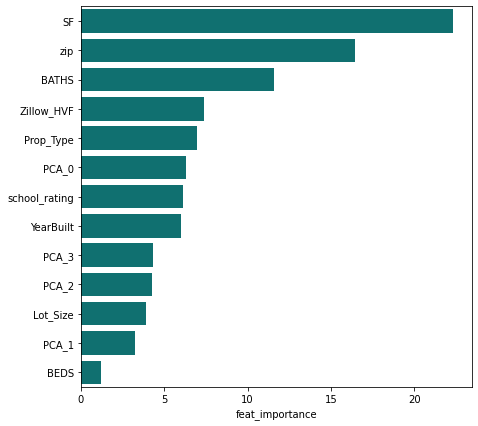

In [68]:
feat_importances = pd.DataFrame(cat.get_feature_importance(), index=X_train_le.columns, columns=['feat_importance'])
feat_importances = feat_importances.sort_values(by='feat_importance', ascending=False)

f, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x='feat_importance', y=feat_importances.index, data=feat_importances, color="teal");

In [69]:
from sklearn.metrics import mean_squared_error
y_pred = cat.predict(X_test_le)
#RMSE
print(np.sqrt(mean_squared_error(y_test,y_pred)))

0.13546468044776117
